# Лабораторная работа №2
#### Выполнил: Нистратов Д.Г. гр.9383 
#### Вариант 12
## Цель работы 
Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.
## Задачи лабораторной работы
1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса.
3. Построить сонограмму по записи своего голоса.

##  Траектория основного тона (F0)

### Загрузка аудио сигнала

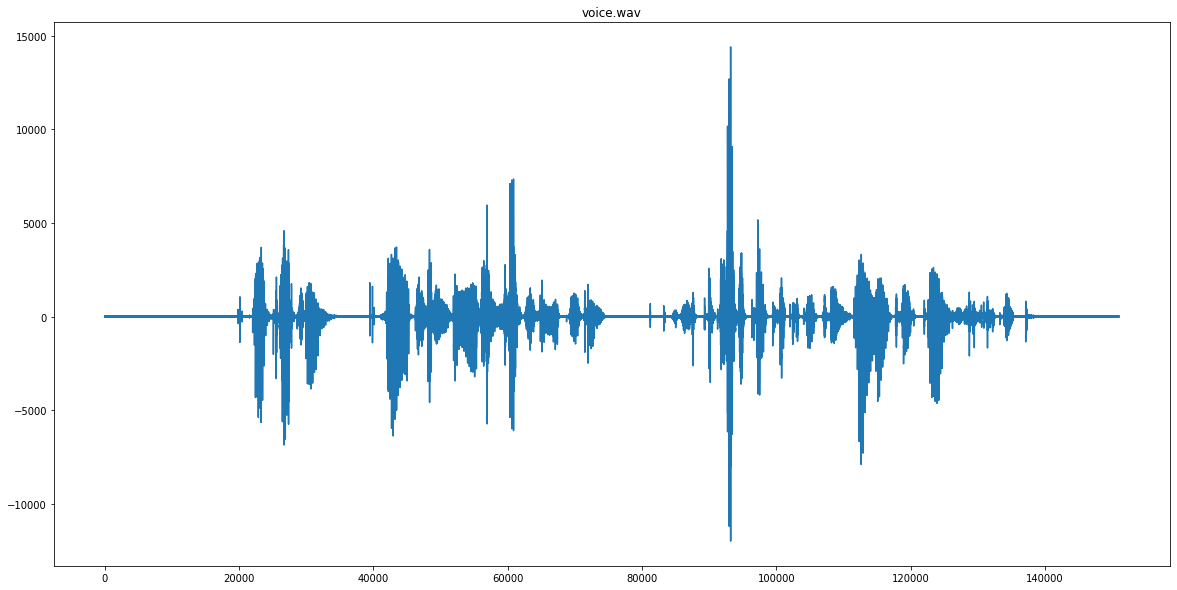

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile


file_name = "voice.wav"

framerate, signal = wavfile.read(file_name)

plt.figure(figsize=(20, 10))
plt.title(file_name)
plt.plot(signal)
plt.show()

### Разбиение сигнала на отрезки длиной N
Разабьем сигнал на отрезки длинны N, с перекрытием каждого отрезка. Сдвиг для перекрытия будет равен 0.25N. Для использования быстрого дискретного преобразования Фурье возьмем N = 2048.<br> Sr - текущее спектральное расшерение, а nl и nu - верхний и нижний диапазон основного тона.

In [2]:
from more_itertools import windowed
N = 2048
Sr = framerate // N
nl = 80 // Sr
nu = 200 // Sr
#split_signal = windowed(signal, N, fillvalue= 0, step=int(0.25 * N))
split_signal = np.array_split(np.array(signal, dtype=np.float64), len(signal) / N)
                        

### Умножение на окно Хемминга
Умножим каждый открезок на окно Хемминга

In [3]:
split_signal = np.array([interval * np.hamming(len(interval)) for interval in split_signal], dtype=object)

### Вычисление ДПФ
Используем быстрое преобразование ДПФ из библиотеки scipy.

In [4]:
import scipy.fft

dftValues = np.array([scipy.fft.fft(interval, n=N) for interval in split_signal], dtype=object)

### Амлитудный спектр

На основе ДПФ вычислим амлитудный спектр в итервале от 0 до N/2, так как значения являются зеркальными.


In [5]:
amplitudeSpectrum = np.array([np.absolute(interval[:len(interval)//2]) for interval in dftValues], dtype=object)

### Основной тон F0
Найдем существенное максимальное значение амлитудного спектра на отрезке nl, nu. Если таковых значений небыло найдено, то пологаем что F0 = 0 и это является интервалом паузы или не вокализированным звуком.

In [6]:
#Получаем F0
def zerosInterval(nl, frame):
    maxIndex = np.argmax(frame)
    maxVal = frame[maxIndex]
    meanVal = np.mean(frame)
    if maxVal > 2.5 * meanVal:
        return nl + maxIndex
    return 0

formantZero = []
mainFreqIndexArr = []
for interval in amplitudeSpectrum:
    mainFreqIndex = zerosInterval(nl, interval[nl:nu + 1])
    mainFreqIndexArr.append(mainFreqIndex)
    formantZero += [Sr * mainFreqIndex for i in range(len(interval))]

### График F0
Построим график основного тона F0

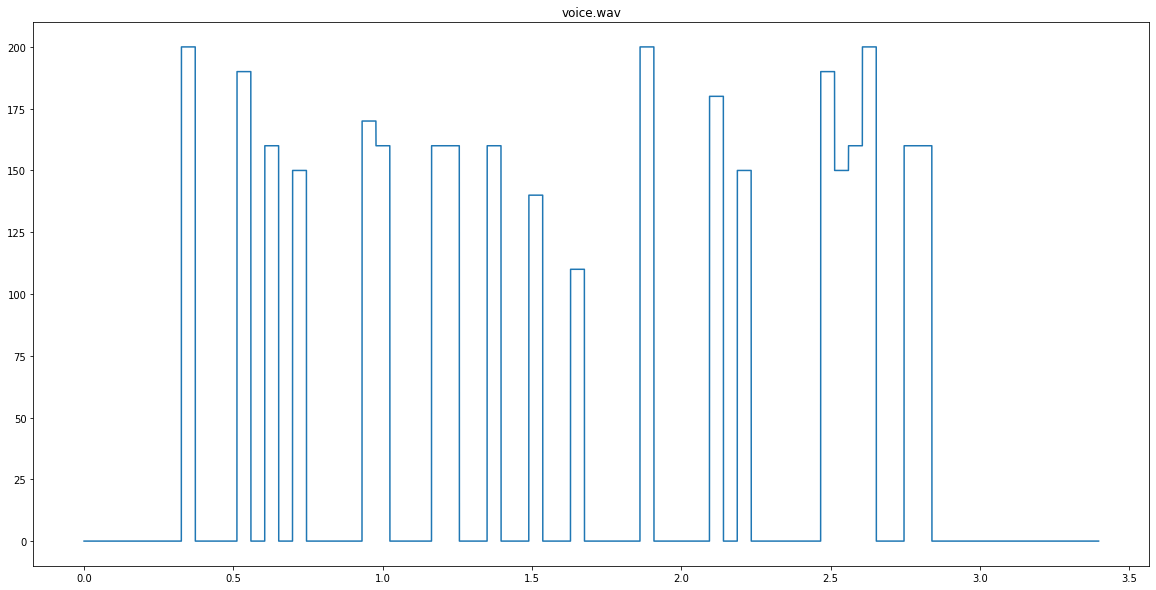

In [7]:
plt.figure(figsize=(20, 10))
plt.title(file_name)
plt.plot(np.arange(len(formantZero))/framerate, formantZero)
plt.show()

## Траектория второй, третьей и четвертой формантных частот
### Формата F1
Найдем F1, для этого в окрестностях точки 2n0 ищем максимальное значение амплитудного спектра, которое существенно меньше значения в точке n0.


In [8]:
def zerosNInterval(nl, frame, prevMax):
    maxIndex = np.argmax(frame)
    maxVal = frame[maxIndex]
    meanVal = np.mean(frame)
    if maxVal > 2.5 * meanVal and maxVal < prevMax:
        return nl + maxIndex
    return 0

#Получаем F1, F2, F3 
def getFN(space):
    formants = []
    for r in range(len(amplitudeSpectrum)):
        mainFreq = mainFreqIndexArr[r]
        interval = amplitudeSpectrum[r]
        if mainFreq != 0:
            lowerBorder = mainFreq * space - (nu - nl) // 2
            upperBorder = lowerBorder + (nu - nl) * 2
            formant = zerosNInterval(lowerBorder, interval[lowerBorder:upperBorder], interval[mainFreq])
            formants += [formant * Sr for j in range(int(len(interval)))]
        else:
            formants += [0 for j in range(int(len(interval)))]
    return formants

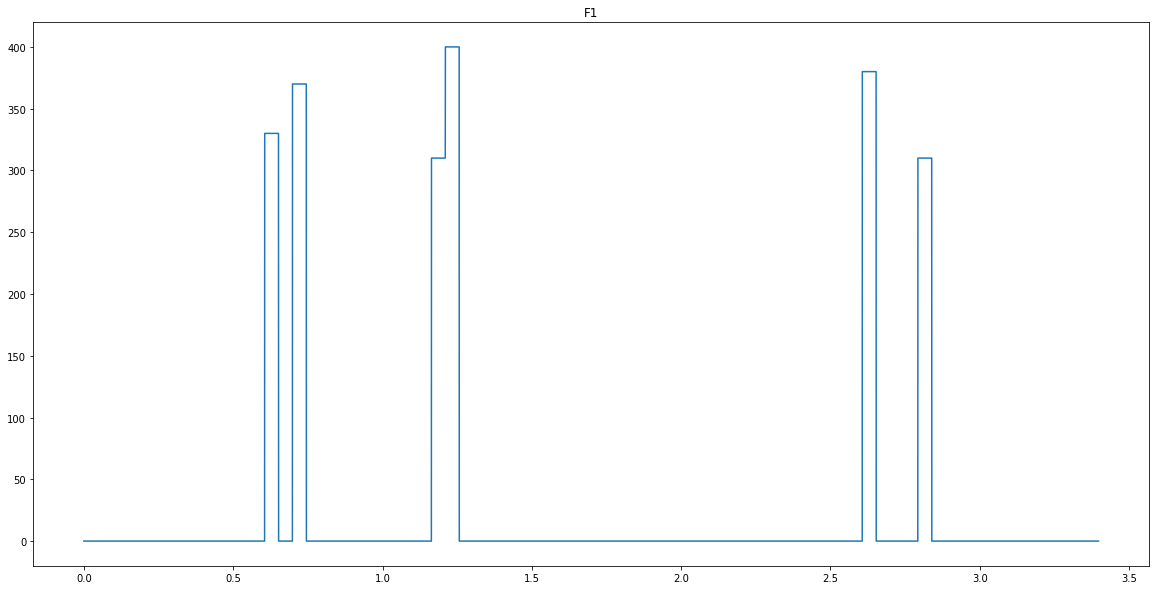

In [9]:
formants = getFN(2)

plt.figure(figsize=(20, 10))
plt.title("F1")
plt.plot(np.arange(len(formants))/framerate, formants)
plt.show()

### Формата F2
Найдем F2, для этого в окрестностях точки 3n0 ищем максимальное значение амплитудного спектра, которое существенно меньше значения в точке n0.

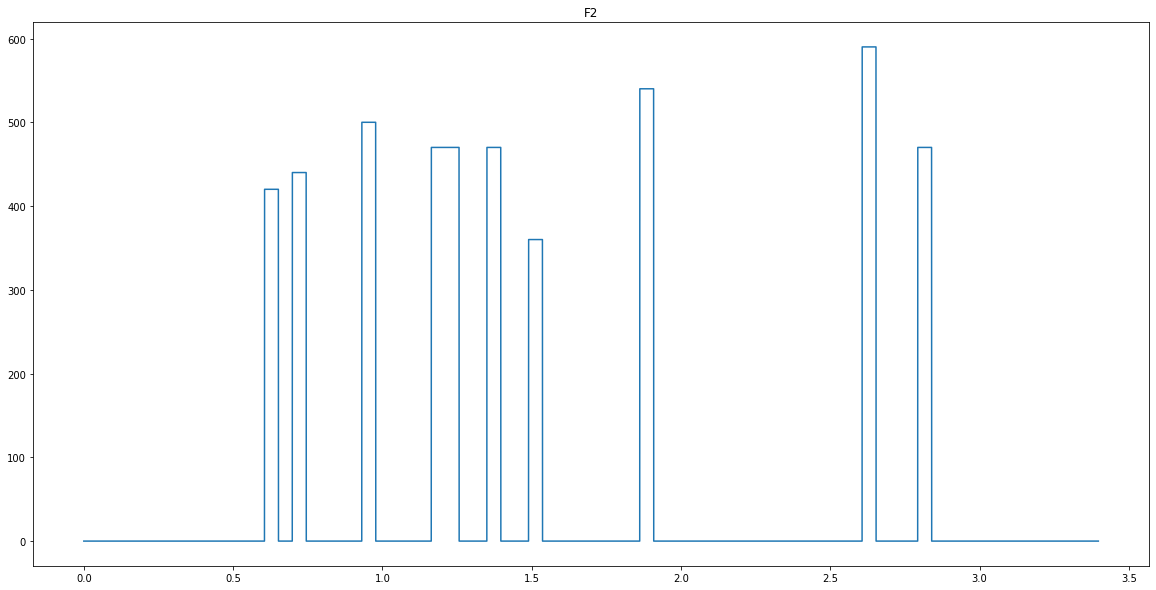

In [10]:
formants = getFN(3)

plt.figure(figsize=(20, 10))
plt.title("F2")
plt.plot(np.arange(len(formants))/framerate, formants)
plt.show()

### Формата F3
Найдем F3, для этого в окрестностях точки 4n0 ищем максимальное значение амплитудного спектра, которое существенно меньше значения в точке n0.

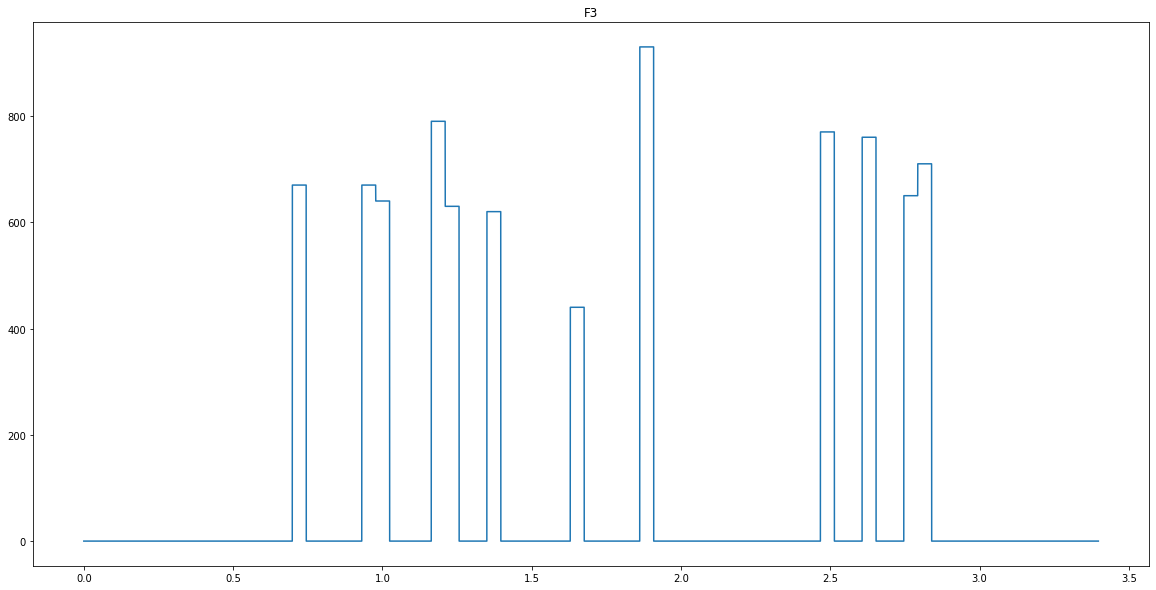

In [11]:
formants = getFN(4)

plt.figure(figsize=(20, 10))
plt.title("F3")
plt.plot(np.arange(len(formants))/framerate, formants)
plt.show()

## Сонограмма
1. Найдем максимальное значение амплитудного спектра для F0 по всему сигналу — AMax.
3. Интенсивность темного (или цвета) определим относительно значения AMax.
4. Интенсивность столбца значений амплитудного спектра выведем в интервале 50− 4000 Hz.

In [12]:
sonogram = np.zeros((len(amplitudeSpectrum[0]),len(amplitudeSpectrum)))
for i, interval in enumerate(amplitudeSpectrum):
    Amax = np.max(interval)
    for j in range(len(interval)):
        hz = j * Sr
        if hz > 50:
            if hz > 4000:
                continue
            sonogram[j][i] = interval[j] / Amax

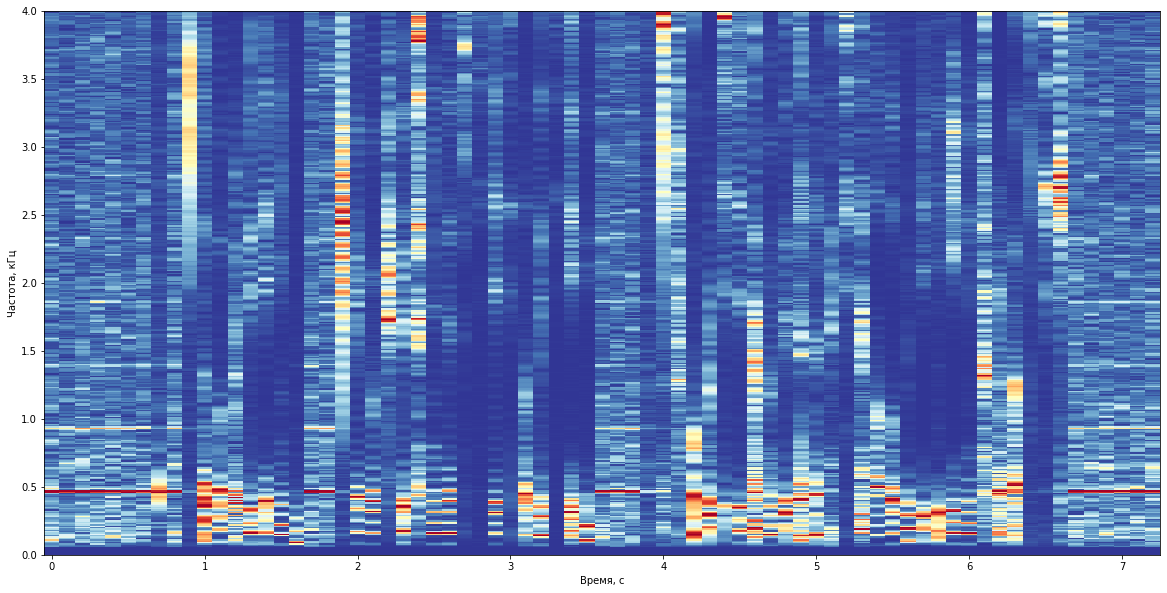

In [13]:
time = np.arange(len(sonogram[0])) / Sr
freqs = np.arange(len(sonogram)) * Sr / 1000

plt.figure(figsize=(20, 10))
plt.xlabel("Время, с")
plt.ylabel("Частота, кГц")
plt.ylim(top=4)
plt.pcolormesh(time, freqs, sonogram, cmap = plt.cm.RdYlBu_r, shading='auto')
plt.show()